In [1]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Literal
from pydantic import BaseModel,Field
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import PydanticOutputParser,StrOutputParser
from dotenv import load_dotenv

In [2]:
load_dotenv()

model = ChatOpenAI()

parser = StrOutputParser()

In [3]:
class ReviewState(TypedDict):

    review : str
    sentiment : Literal['Positive',"Negative"]
    diagnosis : dict
    response : str

In [4]:
class sentiment(BaseModel):

    sentiment : Literal['Positive','Negative'] = Field(required=True,description='Sentiment of the review')

parser1 = PydanticOutputParser(pydantic_object = sentiment)

In [5]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

parser2=PydanticOutputParser(pydantic_object=DiagnosisSchema)

In [10]:
def find_sentiment(state:ReviewState)->dict:

    review = state['review']

    template = PromptTemplate(
        template = 'For the following review find out the sentiment. \n {review} \n {format_instruction}',
        input_variables=['review'],
        partial_variables={'format_instruction':parser1.get_format_instructions()}
    )

    chain = template | model | parser1

    response = chain.invoke({'review':review})

    # output of a pydantic parser is a pydantic object and it's value can be fetch using . operator
    return {'sentiment':response.sentiment}

def check_sentiment(state:ReviewState)->str :

    sentiment = state['sentiment']

    if sentiment=="Positive":
        return 'positive_response'
    else:
        return 'run_diagnosis'

def positive_response(state:ReviewState)->dict:

    review=state['review']

    template=PromptTemplate(
        template="""
        Write a warm thank-you message in response to this review:
        \n\n\"{review}\"\n
        Also, kindly ask the user to leave feedback on our website.
        """,
        input_variables=['review']
    )

    chain = template | model | parser
    response = chain.invoke({'review':review})

    return {'response': response}

def run_diagnosis(state:ReviewState)->dict:

    review=state['review']

    template=PromptTemplate(
        template = """
        Diagnose this negative review:\n\n{review} \n
        Return issue_type, tone, and urgency. \n
        {format_instruction}
    """,
    input_variables=['review'],
    partial_variables={'format_instruction':parser2.get_format_instructions()}
    )

    chain = template | model | parser2

    response = chain.invoke({'review':review})

    return {'diagnosis': response.model_dump()}

def negative_response(state:ReviewState)->dict:

    diagnosis = state['diagnosis']

    template=PromptTemplate(
        template = """
        You are a support assistant.
        The user had a {issue_type} issue, sounded {tone}, and marked urgency as {urgency}.
        Write an empathetic, helpful resolution message.
        """,
        input_variables=["issue_type", "tone", "urgency"]
    )

    chain = template | model | parser
    response = chain.invoke({
        "issue_type": diagnosis['issue_type'],
        "tone": diagnosis['tone'],
        "urgency": diagnosis['urgency']
    })

    return {'response': response}



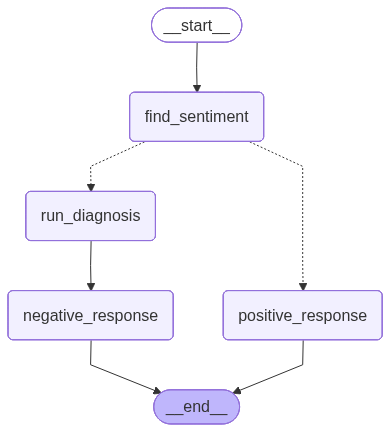

In [17]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment',find_sentiment)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('positive_response',positive_response)
graph.add_node('negative_response',negative_response)

graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges(
    'find_sentiment',
    check_sentiment,
    {
        "positive_response": "positive_response",
        "run_diagnosis": "run_diagnosis"
    }
)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

workflow = graph.compile()

workflow


In [21]:
review = """
I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.
"""

review1 = """
Such an amazing product to have. I request everyone must have this product at least once.Cheers
"""

In [22]:
initial_state = {'review':review1}

final_state = workflow.invoke(initial_state)

final_state

{'review': '\nSuch an amazing product to have. I request everyone must have this product at least once.Cheers\n',
 'sentiment': 'Positive',
 'response': 'Dear valued customer,\n\nThank you so much for your kind words and recommendation of our product! We are thrilled to hear that you are enjoying it and find it amazing to have. Your support means the world to us!\n\nIf you have a moment, we would greatly appreciate it if you could leave a review on our website as well. Your feedback helps us improve and ensures that other customers have a great experience too.\n\nCheers to you and thank you again for choosing our product!\n\nWarm regards, [Your Name]'}